In [ ]:
import torch
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN


from classical import (
    ClassicalMLP,
    train_classical,
    inference_classical,
    plot_pca_decision_boundary_classical,
)
from quantum import (
    QuantumMLP,
    train_quantum,
    inference_quantum_simulator,
    inference_quantum_hardware,
    plot_pca_decision_boundary_quantum_simulator,
)

In [ ]:
# --- Data Prep ---
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

Epoch 5/20 | Loss: 0.7342
Epoch 10/20 | Loss: 0.4107
Epoch 15/20 | Loss: 0.2840
Epoch 20/20 | Loss: 0.1824
torch.Size([30])
------------------------------
       Classical MODEL RESULTS       
------------------------------
Accuracy:           83.33%
Training Time:      0.65563 sec
Inference Time:      0.00013 sec
------------------------------


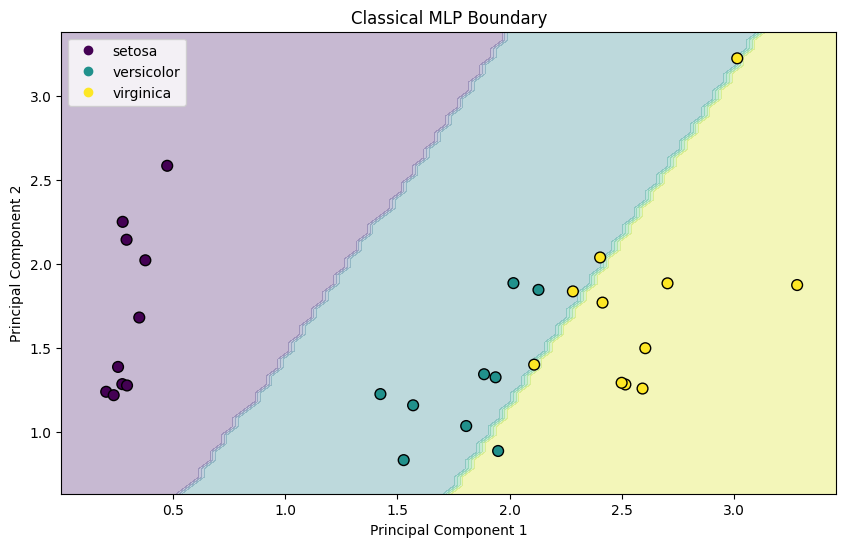

In [3]:
classical_model = ClassicalMLP()

trained_model, training_time = train_classical(
    classical_model, 20, X_train_tensor, y_train_tensor
)
accuracy, inference_time, _ = inference_classical(
    trained_model, X_test_tensor, y_test_tensor
)

print(y_test_tensor.shape)

print("-" * 30)
print("       Classical MODEL RESULTS       ")
print("-" * 30)
print(f"Accuracy:           {accuracy * 100:.2f}%")
print(f"Training Time:      {training_time:.5f} sec")
print(f"Inference Time:      {inference_time:.5f} sec")
print("-" * 30)

# Use the tensors from your successful run
plot_pca_decision_boundary_classical(trained_model, X_test_tensor, y_test_tensor, target_names)

------------------------------
       Quantum Simulator MODEL RESULTS       
------------------------------
Accuracy:           90.00%
Training Time:      377.63473 sec
Inference Time:     0.11295 sec
------------------------------
Plot saved.


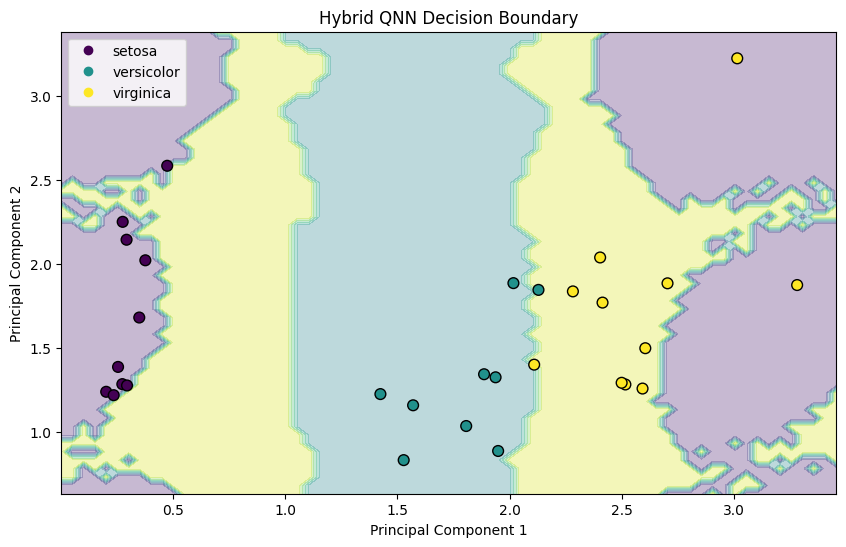

In [7]:
# Circuit Setup
num_qubits = 2
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2, entanglement="linear")

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

observables = [
    SparsePauliOp.from_list([("IZ", 1)]),
    SparsePauliOp.from_list([("ZI", 1)]),
]

# Simulator Run
print("Setting up Simulator...")
estimator = StatevectorEstimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    observables=observables,
    estimator=estimator,
)

quantum_model = QuantumMLP(qnn)

# Train
trained_model_q, training_time_q = train_quantum(
    quantum_model, 300, X_train_tensor, y_train_tensor
)

accuracy_qs, inference_time_qs, predictions_qs = inference_quantum_simulator(
    trained_model_q, X_test_tensor, y_test_tensor
)

print("-" * 30)
print("       Quantum Simulator MODEL RESULTS       ")
print("-" * 30)
print(f"Accuracy:           {accuracy_qs * 100:.2f}%")
print(f"Training Time:      {training_time_q:.5f} sec")
print(f"Inference Time:     {inference_time_qs:.5f} sec")
print("-" * 30)

plot_pca_decision_boundary_quantum_simulator(
    trained_model_q, X_test_tensor, y_test_tensor, target_names
)

In [6]:
RUN_HARDWARE = False

if RUN_HARDWARE:
    accuracy_qh, inference_time_qh, predictions_qh = inference_quantum_hardware(
        qc,
        trained_model_q,
        feature_map,
        ansatz,
        observables,
        X_test_tensor,
        y_test_tensor,
    )

    if predictions_qh is not None:
        print("-" * 30)
        print("       Quantum Hardware MODEL RESULTS       ")
        print("-" * 30)
        print(f"Accuracy:           {accuracy_qh * 100:.2f}%")
        print(f"Inference Time:     {inference_time_qh:.5f} sec")
        print(f"Predictions:        {predictions_qh.tolist()}")
        print("-" * 30)

qiskit_runtime_service._discover_account:WARNING:2025-12-19 20:28:49,651: Loading account with the given token. A saved account will not be used.



--- Connecting to IBM Quantum Hardware ---
Selected Backend: ibm_torino
Transpiling circuit...


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Submitting job to QPU... (This may take a few minutes)
------------------------------
       Quantum Hardware MODEL RESULTS       
------------------------------
Accuracy:           56.67%
Inference Time:     91.81321 sec
Predictions:        [1, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]
------------------------------
